# Removing Trends - Lab

## Introduction

In this lab, you'll practice your detrending skills!

## Objectives

You will be able to:
* Learn how to remove trends and seasonality
* Use a log transformation to minimize non-stationarity
* Use rolling means to reduce non-stationarity
* Use differencing to reduce non-stationarity

## Detrending the Airpassenger data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
#Passengers    144 non-null int64
dtypes: int64(1)
memory usage: 2.2 KB
None


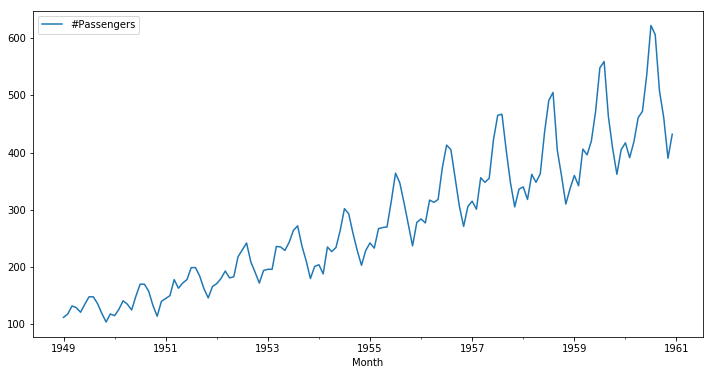

In [19]:
# Import necessary libraries
import pandas as pd
from pandas import Series
import numpy as np
import matplotlib.pylab as plt
from statsmodels.tsa.stattools import adfuller
%matplotlib inline
# Import passengers.csv and set it as a time-series object. Plot the TS
df = pd.read_csv('passengers.csv')
df.Month = pd.to_datetime(df.Month)
df.set_index('Month',inplace=True)
df.plot(figsize=(12,6));
print(df.info())

## Create a stationarity check

At this stage, we can use the code from previous labs to create a function `stationarity_check(ts)` that takes in a time series object and performs stationarity checks including rolling statistics and the Dickey Fuller test. 

We want the output of the function to:
- Plot the original time series along with the rolling mean and rolling standard deviation in one plot
- Output the results of the Dickey-Fuller test

In [29]:
# Create a function to check for the stationarity of a given timeseries using rolling stats and ADF test
def stationarity_check(ts, lags=12):
    #Calculate rolling mean and standard deviation.
    r_mean = ts.rolling(lags).mean()
    r_std = ts.rolling(lags).std()
    #Plot the original data vs. rolling mean and standard deviation
    fig = plt.figure(figsize=(14,7))
    plt.plot(ts,label='Original',color='k')
    plt.plot(r_mean,label='Rolling Mean',color='r')
    plt.plot(r_std,label='Rolling Std',color='b')
    plt.title('Rolling Mean and Standard Deviation')
    plt.legend(loc='best')
    plt.show();
    #Calculate ADF and display results
    results = adfuller(ts[ts.columns[0]])
    df_results = pd.Series(results[:4],index=['Test statistic','p-value','# Lags','# Observaions Used'])
    for key,value in results[4].items():
        df_results[f'Critical value ({key})']= value
    print(df_results)
    return r_mean, r_std, results

Use your newly created function on the airpassenger data set.

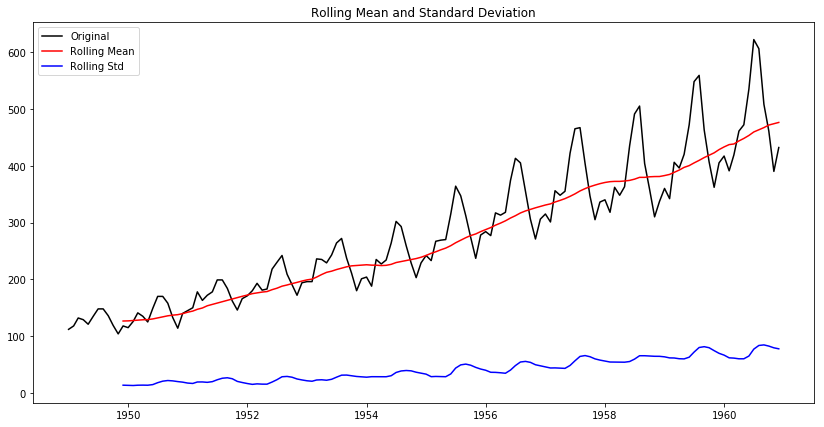

Test statistic            0.815369
p-value                   0.991880
# Lags                   13.000000
# Observaions Used      130.000000
Critical value (1%)      -3.481682
Critical value (5%)      -2.884042
Critical value (10%)     -2.578770
dtype: float64


In [33]:
# Code here
r_mean, r_std, results = stationarity_check(df)

## Perform a log() and sqrt() transform

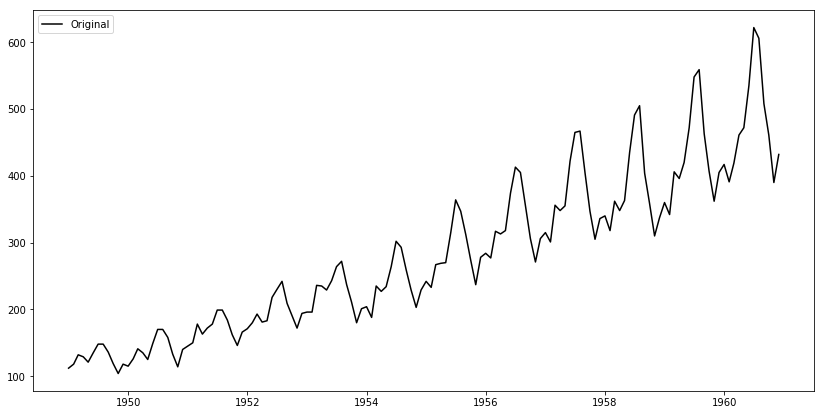

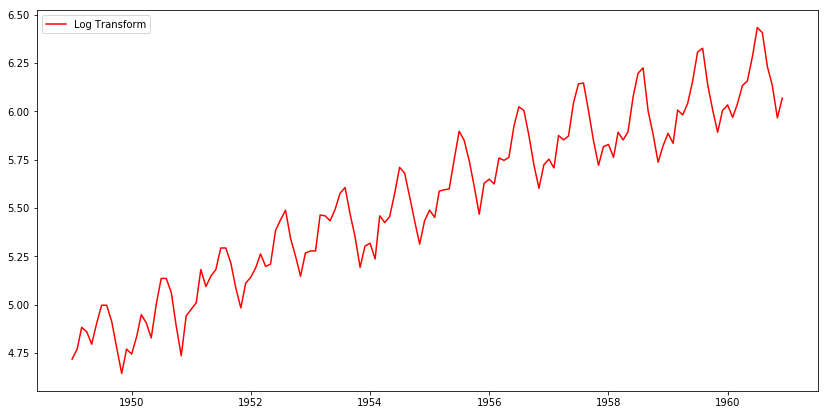

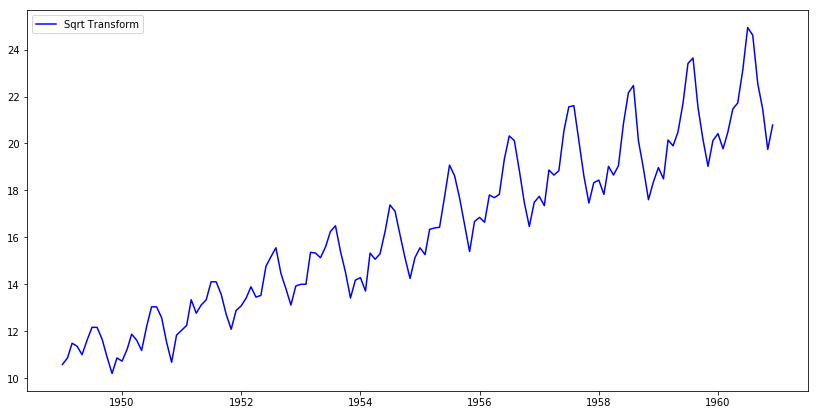

In [31]:
# Log transform timeseries and compare with original to check the effect
df_log = np.log(df)
df_sqrt = np.sqrt(df)
fig = plt.figure(figsize=(14,7))
plt.plot(df,label='Original',color='k')
plt.legend(loc='best')
fig = plt.figure(figsize=(14,7))
plt.plot(df_log,label='Log Transform',color='r')
plt.legend(loc='best')
fig = plt.figure(figsize=(14,7))
plt.plot(df_sqrt,label='Sqrt Transform',color='b')
plt.legend(loc='best')
plt.show();

moving forward, let's keep working with the log transformed data before subtracting rolling mean, differencing, etc.

## Subtracting the rolling mean

Create a rolling mean using your log transformed time series, with a time window of 7. Plot the log-transformed time series and the rolling mean together.

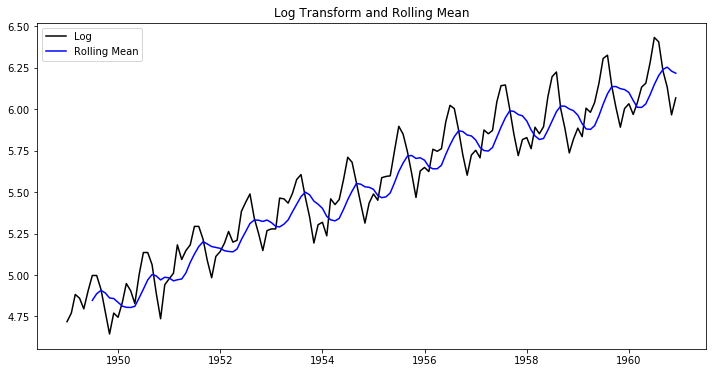

In [37]:
# your code here
r_mean7 = df_log.rolling(7).mean()
fig = plt.figure(figsize=(12,6))
plt.plot(df_log, label='Log',color='k')
plt.plot(r_mean7,label='Rolling Mean',color='b')
plt.legend(loc='best')
plt.title('Log Transform and Rolling Mean')
plt.show()

Now, subtract the rolling mean from the time series, look at the 10 first elements of the result and plot the result.

In [41]:
# Subtract the moving average from the original data and check head for Nans
r_log = df_log-r_mean7
r_log.head()

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN


In [42]:
# Drop the NaN values from timeseries calculated above
r_log.dropna(inplace=True)

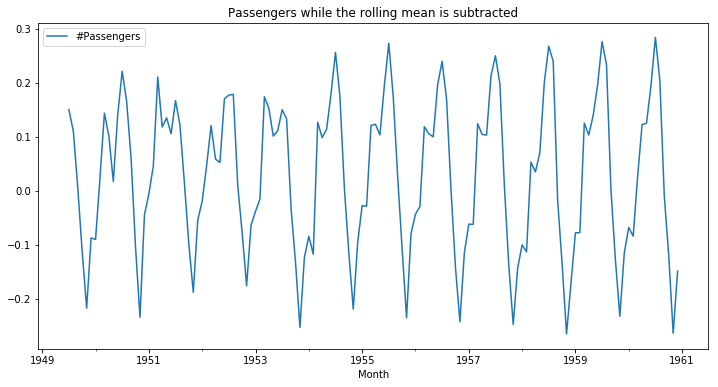

In [47]:
# Plot the result
r_log.plot(figsize=(12,6),title='Passengers while the rolling mean is subtracted')

Finally, use your function `check_stationarity` to see if this series is considered stationary!

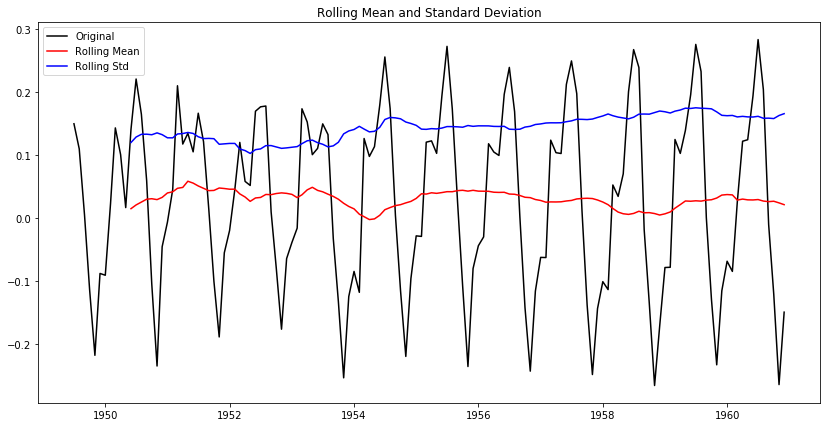

Test statistic           -2.348027
p-value                   0.156946
# Lags                   14.000000
# Observaions Used      123.000000
Critical value (1%)      -3.484667
Critical value (5%)      -2.885340
Critical value (10%)     -2.579463
dtype: float64


In [50]:
# Your code here
a,b,c = stationarity_check(r_log)

### Based on the visuals and on the Dickey-Fuller test, what do you conclude?<br>
Althuog stationarity improved, the test stastistic is not greater in absolute terms that any of the critical values. The p-values is still above the 5% threshold and evend above the 10% significance level. Hence, it is still not stationary enough. 

## Subtracting the weighted rolling mean

Repeat all the above for the *weighter* rolling mean. Start from the log-transformed data again. Compare the Dickey-Fuller Test results. What do you conclude?

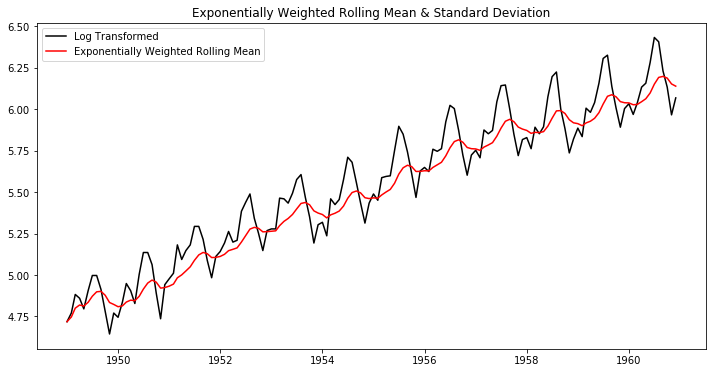

In [57]:
# Use Pandas ewma() to calculate Weighted Moving Average of ts_log
log_ewm = df_log.ewm(halflife=4).mean()

# Plot the original data with exp weighted average
fig = plt.figure(figsize=(12,6))
plt.plot(df_log,label='Log Transformed', color='k')
plt.plot(log_ewm, label='Exponentially Weighted Rolling Mean', color='r')
plt.legend(loc='best')
plt.title('Exponentially Weighted Rolling Mean & Standard Deviation')
plt.show();

In [58]:
# Subtract the moving average from the original data and plot
log_minus_ewm = df_log - log_ewm

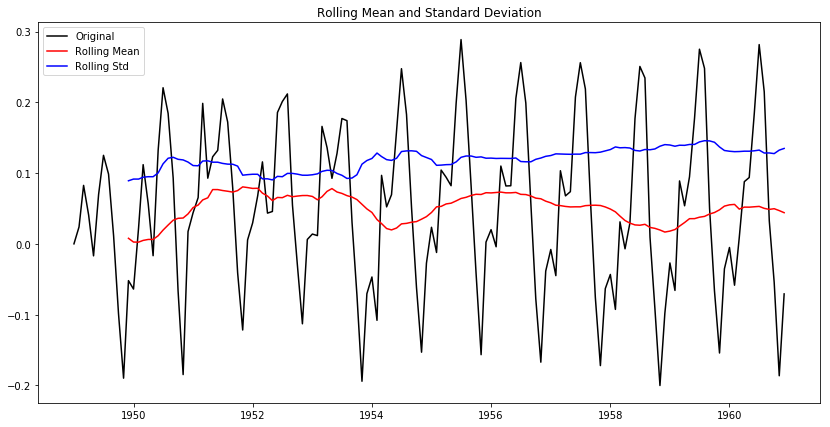

Test statistic           -3.297250
p-value                   0.015002
# Lags                   13.000000
# Observaions Used      130.000000
Critical value (1%)      -3.481682
Critical value (5%)      -2.884042
Critical value (10%)     -2.578770
dtype: float64


In [59]:
# do a stationarity check
a,b,c = stationarity_check(log_minus_ewm)

### Based on the visuals and on the Dickey-Fuller test, what do you conclude?<br>
The exponentially weighted average rolling mean improved stationarity to a 5% significance level. Hence, this method is much better that the previous ones.


## Differencing

Using exponentially weighted moving averages, we seem to have removed the upward trend, but not the seasonality issue. Now use differencing to remove seasonality. Make sure you use the right amount of `periods`. Start from the log-transformed, exponentially weighted rolling mean-subtracted series.

After you differenced the series, run the `stationarity check` again.

In [60]:
# difference your data and look at the head
log_diff = log_minus_ewm.diff(12)
log_diff.head()

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN


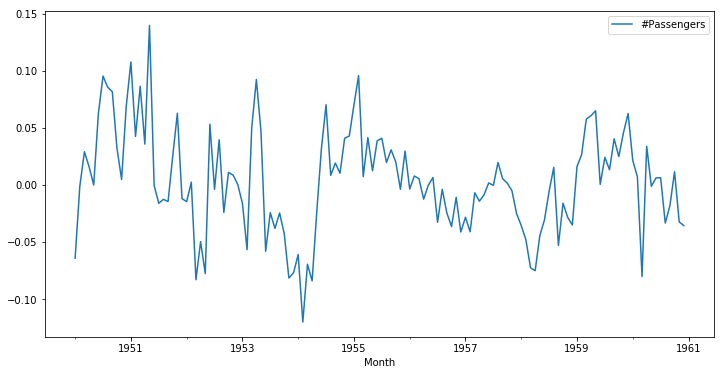

In [63]:
# plot your differenced time series
log_diff.plot(figsize=(12,6));

In [64]:
# drop nas
log_diff.dropna(inplace=True)

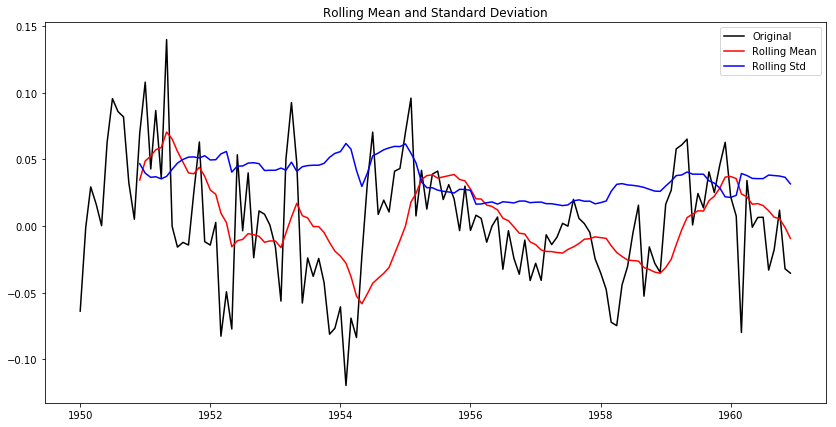

Test statistic           -3.601666
p-value                   0.005729
# Lags                   12.000000
# Observaions Used      119.000000
Critical value (1%)      -3.486535
Critical value (5%)      -2.886151
Critical value (10%)     -2.579896
dtype: float64


In [65]:
# perform the stationarity check
a,b,c = stationarity_check(log_diff)

### Your conclusion<br>
Differencing is the best method to increase stationarity. Eventhough the rolling mean and standard deviation are not constant, they appear to be random and not correlated to time.

## Summary 

In this lab, you learned how to make time series stationary through using log transforms, rolling means and differencing.